For your project on ramp metering with Q-learning, the choice of an optimal state space is critical to balancing performance and computational efficiency. Here’s a suggested setup for the state space that considers key aspects relevant to traffic flow, ramp conditions, and congestion at the merge area.

### Optimal State Space Definition

1. **Traffic Density on Main Road**: 
   - **Description**: Measure the density of vehicles on each lane of the main road segment approaching the on-ramp.
   - **Details**: You could discretize this into a few levels (e.g., low, medium, high) to reduce complexity. For example, divide each lane's density into three states: "low" (few cars), "medium" (moderate congestion), and "high" (heavy congestion).
   - **Reason**: Helps the agent understand congestion levels to decide when to allow vehicles from the ramp.

2. **Traffic Density on Ramp**: 
   - **Description**: Measure the number of vehicles waiting on the ramp.
   - **Details**: Similar to the main road, this can also be divided into levels like low, medium, and high.
   - **Reason**: Indicates the need to release vehicles from the ramp onto the main road.

3. **Traffic Flow Speed on Main Road**: 
   - **Description**: Average speed of vehicles on the main lanes approaching the merge point.
   - **Details**: Again, this can be discretized (e.g., slow, moderate, fast).
   - **Reason**: Provides insight into current traffic flow, helping the agent avoid adding ramp traffic when the main road is moving slowly.

4. **Traffic Light Phase at Merge Point** (if variable phase timing is in place):
   - **Description**: Indicates the current phase of the ramp traffic light (if using a light to meter the flow).
   - **Details**: Binary state (green for "allow merge" or red for "wait").
   - **Reason**: If the ramp metering is controlled by a signal, this helps in timing decisions.

### Example State Representation
Each of the factors can be represented with a few discrete values:

- **Main Road Density**: 3 levels (low, medium, high)
- **Ramp Density**: 3 levels (low, medium, high)
- **Main Road Speed**: 3 levels (slow, moderate, fast)
- **Traffic Light Phase**: 2 levels (green, red)

This gives a state space size of \( 3 \times 3 \times 3 \times 2 = 54 \) possible states. This setup should be manageable for Q-learning while providing the agent enough detail to make informed decisions.

### Suggested Values for Parameters
In your code:
- `STATE_SPACE_SIZE = 54`
- `ACTION_SPACE_SIZE` could be set to the number of possible actions you want the agent to choose from (e.g., adjusting the metering rate in increments or toggling a binary "allow/delay" decision for ramp traffic).

Let me know if you need more help setting up the specific `ACTION_SPACE_SIZE` or coding this state space in Tracy.

In [1]:
import traci
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
SUMO_BINARY = "sumo-gui"    # "sumo-gui" or "sumo" for non-GUI mode
SUMO_CONFIG = "../config/my_simulation.sumocfg"  # path to SUMO config file

# Q-learning parameters
ALPHA = 0.01       # Learning rate
GAMMA = 0.9       # Discount factor
EPSILON = 0.1     # Exploration rate

NBR_EPISODES = 100  #1000
STEPS_PER_EPISODE = 1000    # was 3600s (1 hour simulation steps)

# Environment parameters
STATE_SPACE_SIZE = 27   # 3×3×3=27  (highway_density_discrete x ramp_density_discrete x highway_speed_discrete)   Define based on the range of possible states
ACTION_SPACE_SIZE = 2   # Transit to phase 0, Transit to phase 1
                        # was 3 (SetPhaseDuration 10, SetPhaseDuration 20, SetPhaseDuration 30) Define the number of actions (e.g., different green light durations)

# Initialize Q-table [rows: States; columns: Actions]
q_table = np.zeros((STATE_SPACE_SIZE, ACTION_SPACE_SIZE))

## Helper functions for discretizing the continuous states
Continuous => Discrete state space for Q-Learning 

In [3]:
# Helper functions for discretizing the continuous states
def discretize_density(density):
    if density < 4:      # Define thresholds as needed
        return 0         # Low density
    elif density < 6:  # 15
        return 1         # Medium density
    else:
        return 2         # High density
    
    
def discretize_speed(speed):
    if speed < 8: #10   # Define thresholds as needed
        return 0         # Slow speed
    elif speed < 13: #20
        return 1         # Moderate speed
    else:
        return 2         # Fast speed

In [ ]:
# def get_state():
#     """Retrieve the current state from SUMO."""
#     # Example: measure number of vehicles in specific lanes
#     ramp_queue = traci.lane.getLastStepVehicleNumber("E8_0")  # Replace with your lane ID for the ramp
#     main_queue = traci.lane.getLastStepVehicleNumber("E6_0") + traci.lane.getLastStepVehicleNumber("E6_1") + traci.lane.getLastStepVehicleNumber("E6_2")
#     current_state = (ramp_queue, main_queue)    # Modify based on your state representation
#     return current_state  

def get_state():
    """Retrieve the current state from SUMO and discretize it."""
    # Density on main road
    highway_density = traci.edge.getLastStepVehicleNumber("E6") + traci.edge.getLastStepVehicleNumber("E7")     # traci.lane.getLastStepVehicleNumber("E6_0") + traci.lane.getLastStepVehicleNumber("E6_1") + traci.lane.getLastStepVehicleNumber("E6_2") + traci.lane.getLastStepVehicleNumber("E7_0") + traci.lane.getLastStepVehicleNumber("E7_1") + traci.lane.getLastStepVehicleNumber("E7_2")
    highway_density_discrete = discretize_density(highway_density)

    # Density on ramp
    ramp_density = traci.lane.getLastStepVehicleNumber("E8_0")
    ramp_density_discrete = discretize_density(ramp_density)
    
    # Speed on main road
    highway_speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7")) / 2
    highway_speed_discrete = discretize_speed(highway_speed)
    
    # Traffic light phase
    # traffic_light_phase = traci.trafficlight.getPhase("J11")  # traffic_light_phase = 0 if traci.trafficlight.getPhase("J11") == 0 else 1       # ig: 0 is red (OOOrr, OOOGG, OOOyy)

    
    # Get state & Calculate state index (to be used in q_table)
    state = (highway_density_discrete, ramp_density_discrete, highway_speed_discrete)
    state_index = highway_density_discrete * 9 + ramp_density_discrete * 3 + highway_speed_discrete
    # state_index = highway_density_discrete * 27 + ramp_density_discrete * 9 + highway_speed_discrete * 3 + traffic_light_phase
    # state_index = highway_density * 18 + ramp_density * 6 + highway_speed * 2 + traffic_light_phase
    
    # dens = traci.edge.getLastStepVehicleNumber("E6") + traci.edge.getLastStepVehicleNumber("E7")
    # dens_2 = traci.lane.getLastStepVehicleNumber("E8_0")
    # speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7")) / 2
    # print("==========================")
    # print(f"HIGHWAY DENSITY: {dens}")
    # print(f"RAMP DENSITY: {dens_2}")
    # print(f"HIGHWAY SPEED: {speed}")
    # print(f"TL PHASE: {traffic_light_phase}")

    # phase_name = traci.trafficlight.getPhaseName("J11")
    # phase_dur = traci.trafficlight.getSpentDuration("J11")
    # print(f"CURRENT TL PHASE: {phase_name}, SPENT DURATION: {phase_dur}")

    return state, state_index



def choose_action(state_index):
    """Choose action using epsilon-greedy policy."""
    if random.uniform(0, 1) < EPSILON:
        return random.randint(0, ACTION_SPACE_SIZE - 1)     # Exploration: choose a random action
    else:
        return np.argmax(q_table[state_index])                    # Exploitation: choose the best action based on Q-table
    


def take_action(action):
    """Apply action in SUMO."""
    traci.trafficlight.setPhase("J11", action)

    # if action == 0:
    #     # Short green phase
    #     traci.trafficlight.setPhaseDuration("J11", 0)      # setPhaseDuration(tlsID, phaseDuration): Set the remaining phase duration of the current phase in seconds. This value has no effect on subsquent repetitions of this phase.
    # elif action == 1:
    #     # Medium green phase
    #     traci.trafficlight.setPhaseDuration("J11", 3)
    # elif action == 2:
    #     # Long green phase
    #     traci.trafficlight.setPhaseDuration("J11", 10)
    # elif action == 3:                                   # ??????????????
    #     # Very Long green phase
    #     traci.trafficlight.setPhaseDuration("J11", 20)
    # elif action == 4:                                   # ??????????????
    #     # Very Long green phase
    #     traci.trafficlight.setPhaseDuration("J11", 30)


def calculate_reward(state):
    """Calculate reward based on the current state."""
    # highway_density = state[0]          # highway_density = state % 18 // 6
    # ramp_density = state[1]             # ramp_density = state_index // 18 % 3 
    # highway_speed = state[2]     
    
    highway_density = traci.edge.getLastStepVehicleNumber("E6") + traci.edge.getLastStepVehicleNumber("E7")
    
    # Density on ramp
    ramp_density = traci.lane.getLastStepVehicleNumber("E8_0")
    
    # Speed on main road
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")
    
    reward = - (highway_density + ramp_density) #+ highway_speed # Example: penalize based on queue length
    return reward



def update_q_table(state_index, action, reward, next_state_index):
    """Update Q-table based on Q-learning formula."""
    best_next_action = np.argmax(q_table[next_state_index])
    q_table[state_index, action] += ALPHA * (reward + GAMMA * q_table[next_state_index, best_next_action] - q_table[state_index, action])
    

In [ ]:
episode_rewards = []  # Create an empty list to store episode rewards

# Main training loop
def q_learning(nbr_episodes = NBR_EPISODES):
    traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])

    for episode in range(NBR_EPISODES):     
        state, state_index = get_state()
        total_reward = 0
        
        for step in range(STEPS_PER_EPISODE): # 1-hour simulation, adjust as needed
            action = choose_action(state_index)
            take_action(action)
            traci.simulationStep()
            
            next_state, next_state_index = get_state()
            reward = calculate_reward(next_state)

            # print(f"STEP {step}: STATE: {state}, ACTION: {action}, REWARD: {reward}, {total_reward}, NEXT: {state}")
            
            update_q_table(state_index, action, reward, next_state_index)
            
            state = next_state
            state_index = next_state_index
            total_reward += reward
        
        print(f"Episode {episode + 1}: Total Reward: {total_reward}")
        episode_rewards.append(total_reward)  # Append the total reward for the episode to the list

    traci.close()

    policy = np.argmax(q_table, axis=1)
    return policy


In [6]:
policy_q_learning = q_learning(NBR_EPISODES)

Episode 1: Total Reward: -8508
Episode 2: Total Reward: -7534
Episode 3: Total Reward: -7087
Episode 4: Total Reward: -8290
Episode 5: Total Reward: -7862
Episode 6: Total Reward: -7993
Episode 7: Total Reward: -7793
Episode 8: Total Reward: -8661
Episode 9: Total Reward: -8837
Episode 10: Total Reward: -9287
Episode 11: Total Reward: -8309
Episode 12: Total Reward: -8529
Episode 13: Total Reward: -8711
Episode 14: Total Reward: -8712
Episode 15: Total Reward: -9735
Episode 16: Total Reward: -8442
Episode 17: Total Reward: -9075
Episode 18: Total Reward: -8680
Episode 19: Total Reward: -8132
Episode 20: Total Reward: -7887
Episode 21: Total Reward: -8194
Episode 22: Total Reward: -9889
Episode 23: Total Reward: -9453
Episode 24: Total Reward: -8236
Episode 25: Total Reward: -8149
Episode 26: Total Reward: -8905
Episode 27: Total Reward: -7130
Episode 28: Total Reward: -8872
Episode 29: Total Reward: -9025
Episode 30: Total Reward: -10460
Episode 31: Total Reward: -8650
Episode 32: Tota

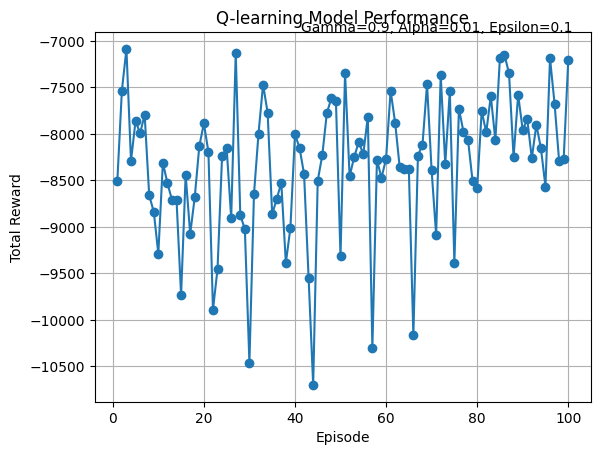

In [ ]:
# Plot the episode rewards
plt.plot(range(1, NBR_EPISODES + 1), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}, Epsilon={EPSILON}'
plt.text(NBR_EPISODES + 1, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()

In [ ]:
# def q_learning(nbr_episodes = NBR_EPISODES):
#     for episode in range(NBR_EPISODES):
#         traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
#         state, state_index = get_state()
#         total_reward = 0
        
#         for step in range(STEPS_PER_EPISODE):  # 1-hour simulation, adjust as needed
#             action = choose_action(state_index)
#             take_action(action)
#             traci.simulationStep()
            
#             next_state, next_state_index = get_state()
#             reward = calculate_reward(next_state)

#             # print(f"STEP {step}: STATE: {state}, ACTION: {action}, REWARD: {reward}, {total_reward}, NEXT: {state}")
            
#             update_q_table(state_index, action, reward, next_state_index)
            
#             state = next_state
#             state_index = next_state_index
#             total_reward += reward
        
#         print(f"Episode {episode + 1}: Total Reward: {total_reward}")
        
#         traci.close()

#     policy = np.argmax(q_table, axis=1)
#     return policy



# # Main training loop
# def q_learning(nbr_episodes = NBR_EPISODES):
#     for episode in range(NBR_EPISODES):
#         traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
#         state, state_index = get_state()
#         total_reward = 0
        
#         for step in range(STEPS_PER_EPISODE):  # 1-hour simulation, adjust as needed
#             action = choose_action(state_index)
#             take_action(action)
#             traci.simulationStep()
            
#             next_state, next_state_index = get_state()
#             reward = calculate_reward(next_state)
            
#             update_q_table(state_index, action, reward, next_state_index)
            
#             state = next_state
#             state_index = next_state_index
#             total_reward += reward
        
#         print(f"Episode {episode + 1}: Total Reward: {total_reward}")
        
#         traci.close()

#     policy = np.argmax(q_table, axis=1)
#     return policy